In [1]:
import pandas as pd
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from datetime import timedelta
import requests

# Stage 1: Preparing Dataset for Model Training

### 1. Gather historical data
### 2. Clean and preprocess data
### 3. Determine the statistics of returns
### 4. Identify outliers historically

In [2]:
def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['daily_return'] = (df['c'] - df['prev_close']) / df['prev_close']
    df['abs_daily_return'] = df['daily_return'].abs()
    return df

def get_top_outliers(df, n=10):
    return df.nlargest(n, 'abs_daily_return')

# Define the API key and base URL
api_key = 'beBybSi8daPgsTp5yx5cHtHpYcrjp5Jq'

# Define the currency pairs and years
pair = "C:USDEUR"
years = range(2010, 2024)

# Initialize DataFrames
stats_data = pd.DataFrame(columns=['Year', 'Mean', 'Variance', 'Skewness', 'Kurtosis'])
full_data = pd.DataFrame()
outliers_data = pd.DataFrame()

# Loop over each year
for year in years:
	# Format the API endpoint
	start_date = f'{year}-01-01'
	end_date = f'{year}-12-31'
	url = f"https://api.polygon.io/v2/aggs/ticker/{pair}/range/1/day/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
	
	# Make the API request
	response = requests.get(url)
	data = response.json()
	
	# Check if the request was successful
	if response.status_code == 200 and 'results' in data:
		# Load data into a DataFrame
		df = pd.DataFrame(data['results'])
        # Converting timestamps
		df['date'] = pd.to_datetime(df['t'], unit='ms')
		df.drop(columns=['t'], inplace=True)
        # Calculating returns
		df = calculate_daily_returns(df)
        
		# Calculate basic statistical properties of the daily returns
		returns = df['daily_return'] 
		mean_return = returns.mean()
		variance_return = returns.var()
		skewness_return = skew(returns)
		kurtosis_return = kurtosis(returns)

		# Collect stats data by year
		year_stats = pd.DataFrame([[year, mean_return, variance_return, skewness_return, kurtosis_return]],
									columns=['Year', 'Mean', 'Variance', 'Skewness', 'Kurtosis'])
		stats_data = pd.concat([stats_data, year_stats], ignore_index=True)

		# Append the data to the full_data DataFrame for the current currency pair
		df['year'] = year
		full_data = pd.concat([full_data, df], ignore_index=True)

		# Find the top 10 outliers based on absolute values of the daily return value
		df['abs_daily_return'] = df['c'].abs()
		outliers = df.nlargest(10, 'abs_daily_return')

		# Append outliers to the outliers_data DataFrame for the current currency pair
		outliers['year'] = year
		outliers_data = pd.concat([outliers_data, outliers], ignore_index=True)

# Sort the data by date so that visualization could be done in a better way         
sorted_full_data = full_data.sort_values(by="date")
sorted_outliers_data = outliers_data.sort_values(by="date")

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_32335/3921182731.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats_data = pd.concat([stats_data, year_stats], ignore_index=True)


In [3]:
sorted_full_data

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,year
0,4,0.7567,0.75650,0.75680,0.75680,0.756500,4,2012-01-29,NaN,NaN,NaN,2012
1,764,0.7609,0.75720,0.76110,0.76430,0.757100,764,2012-01-30,0.75680,0.005682,0.005682,2012
2,750,0.7608,0.76100,0.76460,0.76620,0.756800,750,2012-01-31,0.76110,0.004599,0.004599,2012
3,781,0.7618,0.76470,0.75920,0.76760,0.756800,781,2012-02-01,0.76460,-0.007063,0.007063,2012
4,767,0.7602,0.75920,0.76120,0.76370,0.757800,767,2012-02-02,0.75920,0.002634,0.002634,2012
...,...,...,...,...,...,...,...,...,...,...,...,...
3730,51232,0.9068,0.90747,0.90550,0.90833,0.905100,51232,2023-12-26,0.90747,-0.002171,0.002171,2023
3731,77389,0.9029,0.90557,0.90018,0.90670,0.898796,77389,2023-12-27,0.90550,-0.005875,0.005875,2023
3732,83788,0.9008,0.90018,0.90348,0.90453,0.897500,83788,2023-12-28,0.90018,0.003666,0.003666,2023
3733,78410,0.9040,0.90346,0.90580,0.90625,0.902000,78410,2023-12-29,0.90348,0.002568,0.002568,2023


In [4]:
sorted_outliers_data

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,year
8,2097,0.8156,0.81580,0.81650,0.81862,0.813140,2097,2012-07-11,0.81590,0.000735,0.81650,2012
6,2091,0.8193,0.81670,0.82010,0.82182,0.816660,2091,2012-07-12,0.81650,0.004409,0.82010,2012
9,26,0.8161,0.81550,0.81640,0.81660,0.815500,26,2012-07-15,0.81630,0.000123,0.81640,2012
4,2201,0.8188,0.81450,0.82220,0.82297,0.814400,2201,2012-07-20,0.81450,0.009454,0.82220,2012
2,26,0.8247,0.82460,0.82450,0.82500,0.824200,26,2012-07-22,0.82220,0.002797,0.82450,2012
...,...,...,...,...,...,...,...,...,...,...,...,...
113,118565,0.9528,0.95524,0.95150,0.95681,0.949200,118565,2023-10-04,0.95500,-0.003665,0.95150,2023
117,128469,0.9448,0.94127,0.94914,0.95001,0.939673,128469,2023-10-12,0.94126,0.008372,0.94914,2023
114,124263,0.9499,0.94911,0.95090,0.95278,0.946880,124263,2023-10-13,0.94914,0.001854,0.95090,2023
116,4681,0.9505,0.95103,0.95034,0.95138,0.949990,4681,2023-10-15,0.95090,-0.000589,0.95034,2023


In [5]:
stats_data

,Year,Mean,Variance,Skewness,Kurtosis
0,2012,0.000015,0.000023,NaN,NaN
1,2013,-0.000120,0.000021,NaN,NaN
2,2014,0.000489,0.000015,NaN,NaN
3,2015,0.000369,0.000049,NaN,NaN
4,2016,0.000113,0.000022,NaN,NaN
5,2017,-0.000412,0.000017,NaN,NaN
6,2018,0.000151,0.000017,NaN,NaN
7,2019,0.000072,0.000008,NaN,NaN
8,2020,-0.000251,0.000019,NaN,NaN
9,2021,0.000201,0.000010,NaN,NaN


Skewness and Kurtosis (NaN): The NaN values likely indicate that daily returns for many years are very close to zero with little variance, thus not allowing for a meaningful calculation of skewness and kurtosis. This could mean the market is highly stable on a day-to-day basis, with changes being very subtle.

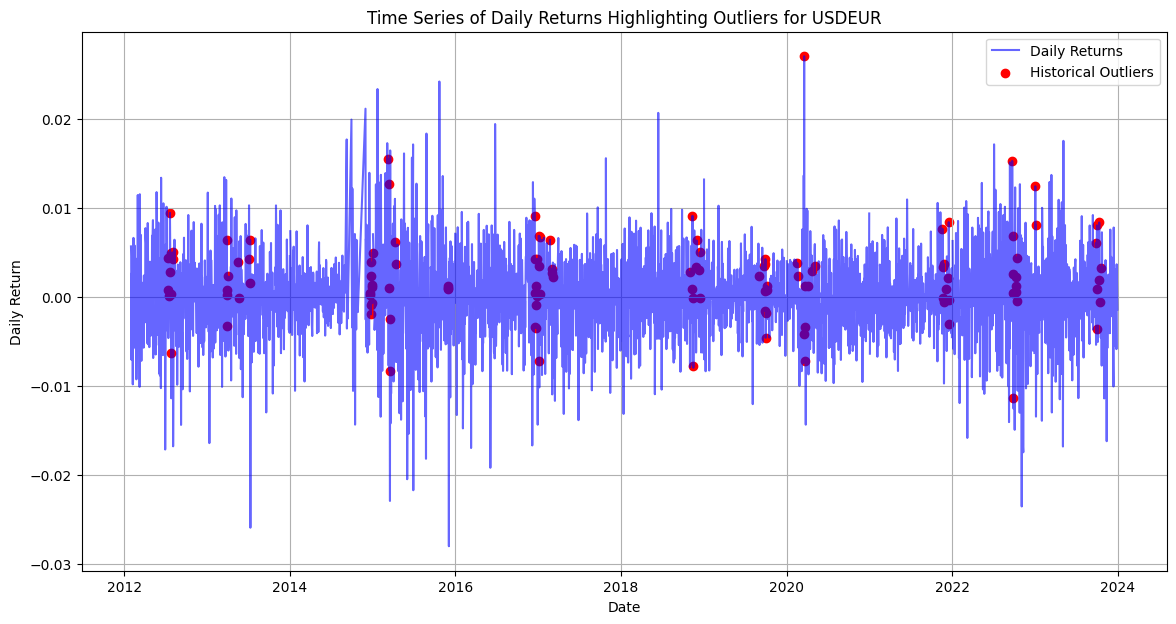

In [6]:
def plot_data_with_outliers(full_data, outliers_data):
    plt.figure(figsize=(14, 7))
    plt.plot(full_data['date'], full_data['daily_return'], label='Daily Returns', color='blue', alpha=0.6)
    plt.scatter(outliers_data['date'], outliers_data['daily_return'], color='red', label='Historical Outliers')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.title('Time Series of Daily Returns Highlighting Outliers for USDEUR')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot data with outliers
plot_data_with_outliers(sorted_full_data, outliers_data)

### 5. Analyze pre- and post-outlier performance
### 6. Create probability distributions for these periods

In [7]:
# Convert dates in dataset to datetime objects
sorted_outliers_data['date'] = pd.to_datetime(sorted_outliers_data['date'])

date_ranges = pd.DataFrame({
    "start_date": sorted_outliers_data['date'] - timedelta(days=3),
    "end_date": sorted_outliers_data['date'] + timedelta(days=3),
    "outlier_date": sorted_outliers_data['date'],
    "year": sorted_outliers_data['year']
})

date_ranges

,start_date,end_date,outlier_date,year
8,2012-07-08,2012-07-14,2012-07-11,2012
6,2012-07-09,2012-07-15,2012-07-12,2012
9,2012-07-12,2012-07-18,2012-07-15,2012
4,2012-07-17,2012-07-23,2012-07-20,2012
2,2012-07-19,2012-07-25,2012-07-22,2012
...,...,...,...,...
113,2023-10-01,2023-10-07,2023-10-04,2023
117,2023-10-09,2023-10-15,2023-10-12,2023
114,2023-10-10,2023-10-16,2023-10-13,2023
116,2023-10-12,2023-10-18,2023-10-15,2023


In [8]:
def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['returns'] = (df['c'] - df['prev_close']) / df['prev_close']
    return df

def fetch_and_process_hourly_data(symbol, start_date, end_date, api_key):
    # Format the dates as strings for URL
    formatted_start_date = start_date.strftime('%Y-%m-%d')
    formatted_end_date = end_date.strftime('%Y-%m-%d')

    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/hour/{formatted_start_date}/{formatted_end_date}?apiKey={api_key}"
    response = requests.get(url)
    response_data = response.json()

    if response.status_code != 200 or 'results' not in response_data:
        print(f"Failed to fetch data or 'results' not in response: {response.status_code} - {response.text}")
        return None

    df = pd.DataFrame(response_data['results'])
    df['date'] = pd.to_datetime(df['t'], unit='ms')
    df.drop(columns=['t'], inplace=True)

    hourly_data = calculate_daily_returns(df)
    hourly_data.set_index('date', inplace=True)

    # Create full index from start_date to end_date at hourly frequency
    full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')

    # Reindex hourly_data using the full index, filling missing rows with NaN
    hourly_data = hourly_data.reindex(full_index)

    hourly_data.reset_index(inplace=True)
    hourly_data.rename(columns={'index': 'date'}, inplace=True)

    return hourly_data

In [9]:
# Initialize empty DataFrame
all_data = pd.DataFrame()

for index, row in date_ranges.iterrows():
	# Convert start_date, end_date, and outlier_date to Timestamp for consistent comparison
	start_date_ts = pd.Timestamp(row['start_date'])
	end_date_ts = pd.Timestamp(row['end_date']) + pd.Timedelta(days=1)  # Extend the end date by one additional day
	outlier_date_ts = pd.Timestamp(row['outlier_date'])

	# Get hourly data for the range including 3 days before and after the outlier
	hourly_data = fetch_and_process_hourly_data(pair, start_date_ts, end_date_ts, api_key)

	# all_data = pd.concat([all_data, hourly_data])

	# Check if hourly_data is not None before processing
	if hourly_data is not None:
		# prior_data from start_date to outlier_date inclusive
		prior_data = hourly_data[(hourly_data['date'] >= start_date_ts) & (hourly_data['date'] < outlier_date_ts)]
		prior_data["day type"] = "prior day"

		# outlier_data is for the hourly data on the day of the outlier
		outlier_data = hourly_data[(hourly_data['date'].dt.date == outlier_date_ts.date())]
		outlier_data["day type"] = "outlier day"

		# post_data from the day after outlier_date to end_date
		post_outlier_ts = outlier_date_ts + pd.Timedelta(days=1)  # Starting the day after the outlier_date
		post_data = hourly_data[(hourly_data['date'] >= post_outlier_ts) & (hourly_data['date'] <= end_date_ts)]
		post_data["day type"] = "post day"

		# Concatenate the data from this iteration to the cumulative DataFrame
		all_data = pd.concat([all_data, prior_data, outlier_data, post_data])

	else:
		print(f"Data not available for symbol {pair} from {row['start_date'].date()} to {row['end_date'].date()}")

# Optionally, you can reset the index of the final DataFrame if it becomes non-unique after concatenations
all_data.reset_index(drop=True, inplace=True)

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_32335/4033729921.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_32335/2924080159.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_32335/2924080159.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

Failed to fetch data or 'results' not in response: 200 - {"ticker":"C:USDEUR","queryCount":0,"resultsCount":0,"adjusted":true,"status":"OK","request_id":"bf1eda052b49d408886d60599da74e22"}
Data not available for symbol C:USDEUR from 2019-09-22 to 2019-09-28
Failed to fetch data or 'results' not in response: 200 - {"ticker":"C:USDEUR","queryCount":0,"resultsCount":0,"adjusted":true,"status":"OK","request_id":"2b72ac8e93c4f0faca2d72ebcbe15f52"}
Data not available for symbol C:USDEUR from 2019-09-23 to 2019-09-29
Failed to fetch data or 'results' not in response: 200 - {"ticker":"C:USDEUR","queryCount":0,"resultsCount":0,"adjusted":true,"status":"OK","request_id":"6a27a8df469895d298d3a7d287457a73"}
Data not available for symbol C:USDEUR from 2019-09-24 to 2019-09-30
Failed to fetch data or 'results' not in response: 200 - {"ticker":"C:USDEUR","queryCount":0,"resultsCount":0,"adjusted":true,"status":"OK","request_id":"384a82f32530927275d1ddc0c8ac4d9d"}
Data not available for symbol C:USDEU

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_32335/4033729921.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_32335/2924080159.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_32335/2924080159.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [10]:
# all_data.to_csv("USDEUR_hourly.csv")

In [11]:
# # Convert start_date, end_date, and outlier_date to Timestamp for consistent comparison
# start_date_ts = pd.Timestamp("2010-05-22")
# end_date_ts = pd.Timestamp("2010-05-28")
# outlier_date_ts = pd.Timestamp("2010-05-25")

# # Get hourly data for the range including 3 days before and after the outlier
# hourly_data = fetch_and_process_hourly_data(pair, "2010-05-22", "2010-05-28", api_key)

# # Check if hourly_data is not None before processing
# if hourly_data is not None:
# 	# prior_data from start_date to outlier_date inclusive
# 	prior_data = hourly_data[(hourly_data['date'] >= start_date_ts) & (hourly_data['date'] <= outlier_date_ts)]
# 	prior_data["day type"] = "prior day"
	
# 	# post_data from the day after outlier_date to end_date
# 	post_outlier_ts = outlier_date_ts + pd.Timedelta(days=1)  # Starting the day after the outlier_date
# 	post_data = hourly_data[(hourly_data['date'] >= post_outlier_ts) & (hourly_data['date'] <= end_date_ts)]
# 	post_data["day type"] = "post day"

In [12]:
# hourly_data

In [13]:
# prior_data

In [14]:
# post_data

In [15]:
# # Assuming 'hourly_data' is your DataFrame and 'date' is the column with datetime objects
# unique_dates = all_data['date'].dt.date.unique()

# # Printing all unique dates
# print("Unique Dates:")
# for date in unique_dates:
#     print(date)

In [16]:
# # Assuming 'hourly_data' is your DataFrame and 'date' is the column with datetime objects
# unique_dates = date_ranges['outlier_date'].dt.date.unique()

# # Printing all unique dates
# print("Unique Dates:")
# for date in unique_dates:
#     print(date)